***
# ISOM3360 Data Mining for Business Analytics
## Group 23 Project Code - Credit Card Defaultee Analysis
### Part 2.2 - Logistic Regression Classifier
***

Name: LAM, Ho Chit  
ITSC: hclamao   
SID: 20607878 

Name: LEE, Ho Wan Owen  
ITSC: hwolee  
SID: 20604852

Name: LEE, Wai Chung  
ITSC: wcleeaj  
SID: 20702733

### Workflow of this notebook (TBC)

1. Perform data preprocessing specific to Logistic Regression Model
   - However, logistic regression can use the exact same data preprocessing workflow as for decision tree.
   - To save computation time, the preprocessed final version of data from decision tree is used.
   - For effective model comparison, the 20 predictors used in the final decision tree shall be the only predictors used in this analysis.
2. Create Logistic Regression model
3. Evaluate model
4. Experiment with L1 (Lasso) and L2 (Ridge) regularization
5. GridSearchCV hyperparameter tuning

### Data preprocessing (con't)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
# train = pd.read_csv('train.csv', index_col = 'SK_ID_CURR')
raw_df = pd.read_csv('decision_tree/raw_no_missing.csv', index_col='SK_ID_CURR')

### Perform one-hot encoding

In [5]:
raw_df = pd.get_dummies(raw_df, columns=['NAME_CONTRACT_TYPE','OCCUPATION_TYPE','FLAG_OWN_CAR','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE','MALE'],drop_first = True)

#p.s. for Naive Bayes Classification, set drop_first = False. Also, no need modification on MALE and FEMALE.
# Also for NB, do not drop Female
raw_df = raw_df.drop(columns='FEMALE')

In [6]:
raw_df.isnull().sum()

TARGET                                               0
CNT_CHILDREN                                         0
AMT_INCOME_TOTAL                                     0
AMT_CREDIT                                           0
AMT_ANNUITY                                          0
AMT_GOODS_PRICE                                      0
REGION_POPULATION_RELATIVE                           0
DAYS_BIRTH                                           0
DAYS_EMPLOYED                                        0
DAYS_REGISTRATION                                    0
DAYS_ID_PUBLISH                                      0
FLAG_MOBIL                                           0
FLAG_EMP_PHONE                                       0
FLAG_WORK_PHONE                                      0
FLAG_CONT_MOBILE                                     0
FLAG_PHONE                                           0
FLAG_EMAIL                                           0
CNT_FAM_MEMBERS                                      0
REGION_RAT

### Select 20 predictors used (same as in decision tree)

In [7]:
columns = ['EXT_SOURCE_3','EXT_SOURCE_2','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working','DAYS_LAST_PHONE_CHANGE','NAME_EDUCATION_TYPE_Secondary / secondary special','MALE_True','DAYS_ID_PUBLISH','NAME_INCOME_TYPE_Pensioner','REG_CITY_NOT_WORK_CITY','DAYS_REGISTRATION','REG_CITY_NOT_LIVE_CITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','NAME_CONTRACT_TYPE_Revolving loans','LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']
raw_df = raw_df[columns]
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 21 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   EXT_SOURCE_3                                       307511 non-null  float64
 1   EXT_SOURCE_2                                       307511 non-null  float64
 2   DAYS_BIRTH                                         307511 non-null  int64  
 3   REGION_RATING_CLIENT_W_CITY                        307511 non-null  int64  
 4   NAME_EDUCATION_TYPE_Higher education               307511 non-null  int64  
 5   NAME_INCOME_TYPE_Working                           307511 non-null  int64  
 6   DAYS_LAST_PHONE_CHANGE                             307511 non-null  float64
 7   NAME_EDUCATION_TYPE_Secondary / secondary special  307511 non-null  int64  
 8   MALE_True                                          307511 non-null  u

### Balancing the data

In [8]:
print("Out of ", raw_df.shape[0], " customers, only", raw_df['TARGET'].sum(), " customers default!")

Out of  307511  customers, only 24825  customers default!


#### Downsample the non-default cases

In [9]:
balanced_train = raw_df.drop(raw_df[raw_df.TARGET==0].index[0:257861])
print("Out of ", balanced_train.shape[0], " customers, ", balanced_train['TARGET'].sum(), " customers default!")

Out of  49650  customers,  24825  customers default!


In [10]:
numerlist = []

for col in raw_df:
    if raw_df[col].nunique() > 2:
        numerlist.append(col)
    # print(f"{col} has unique values of {raw_df[col].unique()}" if raw_df[col].nunique() < 3 else f"{col} is definitely not dummy.")
        
numerlist


['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [11]:
# normalization

for i in numerlist:
    amt4max = balanced_train[i].max()
    amt4min = balanced_train[i].min()
    balanced_train[i] = (balanced_train[i] - amt4min) / (amt4max - amt4min)
balanced_train.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE_Secondary / secondary special,MALE_True,DAYS_ID_PUBLISH,...,REG_CITY_NOT_WORK_CITY,DAYS_REGISTRATION,REG_CITY_NOT_LIVE_CITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,NAME_CONTRACT_TYPE_Revolving loans,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
count,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,...,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000
mean,0.521109,0.546019,0.552565,0.539476,0.206244,0.560302,0.786139,0.744209,0.382276,0.538404,...,0.263243,0.792387,0.095811,0.118231,0.271758,0.082377,0.198449,0.027685,0.019638,0.500000
std,0.208307,0.242866,0.246220,0.252388,0.404612,0.496355,0.191244,0.436309,0.485948,0.243818,...,0.440397,0.149787,0.294334,0.085527,0.180882,0.274940,0.398836,0.079704,0.065490,0.500005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380107,0.360559,0.352951,0.500000,0.000000,0.000000,0.645099,0.000000,0.000000,0.322467,...,0.000000,0.689419,0.000000,0.049383,0.126766,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.569889,0.602987,0.576892,0.500000,0.000000,1.000000,0.837048,1.000000,0.000000,0.511803,...,0.000000,0.812805,0.000000,0.102132,0.253810,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.654145,0.744940,0.759490,0.500000,0.000000,1.000000,0.942727,1.000000,1.000000,0.749599,...,1.000000,0.919007,0.000000,0.158249,0.359278,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Let's build our first logistic regression model!

In [12]:
import sys
sys.path.insert(0, "..")

In [13]:
from utils.constants import random_state
from sklearn.model_selection import train_test_split
# Split the data into training and test.

y = balanced_train[['TARGET']]
X = balanced_train.drop(columns=['TARGET'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', C=1.0, solver='saga', random_state=random_state)

In [15]:
model.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=3360, solver='saga')

In [16]:
from utils.analysis import preds_analysis

# prediction analysis on train data
preds_analysis(y_train, model.predict(X_train), "Train")

---------- Evaluation (Train) ----------

Accuracy: 0.6671953675730111
Precision: 0.6698701564257233
Recall: 0.6596526554241128
F1 Score: 0.6647221447231593
Confusion matrix:
 [[13397  6458]
 [ 6761 13104]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67     19855
           1       0.67      0.66      0.66     19865

    accuracy                           0.67     39720
   macro avg       0.67      0.67      0.67     39720
weighted avg       0.67      0.67      0.67     39720



In [17]:
# prediction analysis on test data
preds_analysis(y_test, model.predict(X_test), "Test")

---------- Evaluation (Test) ----------

Accuracy: 0.6630412890231622
Precision: 0.6659810777457836
Recall: 0.6528225806451613
F1 Score: 0.6593361840765628
Confusion matrix:
 [[3346 1624]
 [1722 3238]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      4970
           1       0.67      0.65      0.66      4960

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930



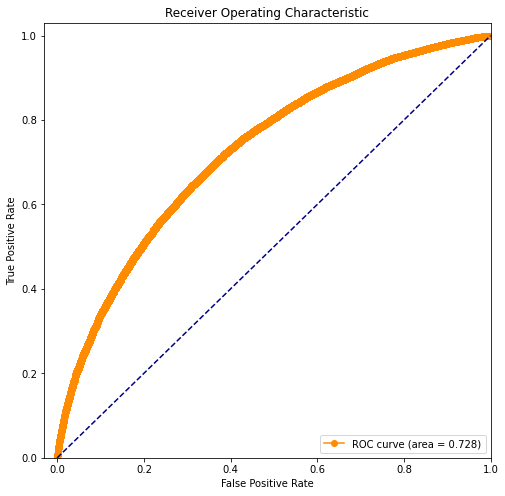

The AUC score for this model is 0.7277033017440881.


In [18]:
# perform model analysis
from utils.analysis import model_eval

model_eval(model, X_train, y_train['TARGET'], cv=5)

### Hyperparameter tuning via Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV

try_grid = {"C": [10**i for i in np.arange(-1, 2, 0.1)], "penalty": ['none', 'l1', 'l2']}

#### Using accuracy as criterion

In [20]:
LRM = GridSearchCV(LogisticRegression(solver='saga', random_state=random_state), try_grid, cv=10, scoring="accuracy")

In [21]:
LRM.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=3360, solver='saga'),
             param_grid={'C': [0.1, 0.12589254117941673, 0.15848931924611134,
                               0.19952623149688792, 0.25118864315095796,
                               0.31622776601683783, 0.39810717055349715,
                               0.5011872336272721, 0.630957344480193,
                               0.7943282347242812, 0.9999999999999994,
                               1.2589254117941662, 1.5848931924611125,
                               1.9952623149688788, 2.5118864315095784,
                               3.162277660168376, 3.981071705534969,
                               5.01187233627272, 6.309573444801926,
                               7.943282347242805, 9.99999999999999,
                               12.589254117941662, 15.84893192461111,
                               19.95262314968877, 25.11886431509577,
                               31.62277660168376, 39

In [22]:
LRM.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [23]:
LRM.best_score_

0.6666666666666667

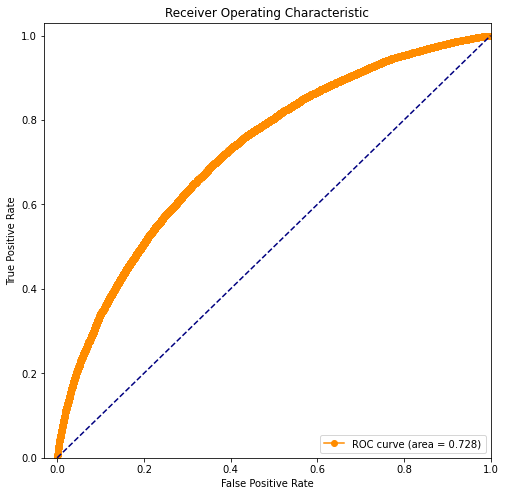

The AUC score for this model is 0.7278614353762741.


In [24]:
model = LogisticRegression(solver='saga', random_state=random_state, **LRM.best_params_)
model_eval(model, X_train, y_train['TARGET'], cv=10)

In [25]:
model.fit(X_train, y_train)
preds_analysis(y_train, model.predict(X_train), "Train")
y_pred = model.predict(X_test)
preds_analysis(y_test, y_pred, "Test")

---------- Evaluation (Train) ----------

Accuracy: 0.6672457200402819
Precision: 0.6696264543784446
Recall: 0.660558771709036
F1 Score: 0.6650617064950205
Confusion matrix:
 [[13381  6474]
 [ 6743 13122]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67     19855
           1       0.67      0.66      0.67     19865

    accuracy                           0.67     39720
   macro avg       0.67      0.67      0.67     39720
weighted avg       0.67      0.67      0.67     39720

---------- Evaluation (Test) ----------

Accuracy: 0.6637462235649547
Precision: 0.6668038691088701
Recall: 0.6532258064516129
F1 Score: 0.6599450045829515
Confusion matrix:
 [[3351 1619]
 [1720 3240]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      4970
           1       0.67      0.65      0.66      4960

    accuracy                           0.66      9930

#### Using roc_auc as criterion

In [26]:
LRM = GridSearchCV(LogisticRegression(solver='saga', random_state=random_state), try_grid, cv=10, scoring="roc_auc")

In [27]:
LRM.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=3360, solver='saga'),
             param_grid={'C': [0.1, 0.12589254117941673, 0.15848931924611134,
                               0.19952623149688792, 0.25118864315095796,
                               0.31622776601683783, 0.39810717055349715,
                               0.5011872336272721, 0.630957344480193,
                               0.7943282347242812, 0.9999999999999994,
                               1.2589254117941662, 1.5848931924611125,
                               1.9952623149688788, 2.5118864315095784,
                               3.162277660168376, 3.981071705534969,
                               5.01187233627272, 6.309573444801926,
                               7.943282347242805, 9.99999999999999,
                               12.589254117941662, 15.84893192461111,
                               19.95262314968877, 25.11886431509577,
                               31.62277660168376, 39

In [28]:
LRM.best_params_

{'C': 0.12589254117941673, 'penalty': 'l2'}

In [29]:
LRM.best_score_

0.7278704115741272

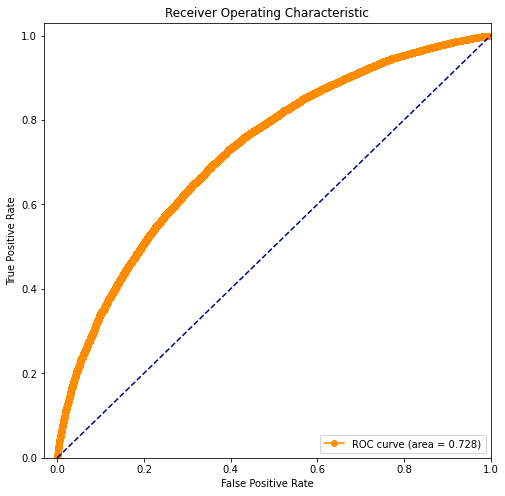

The AUC score for this model is 0.7278629008207821.


In [30]:
model = LogisticRegression(solver='saga', random_state=random_state, **LRM.best_params_)
model_eval(model, X_train, y_train['TARGET'], cv=10)

In [31]:
model.fit(X_train, y_train)
preds_analysis(y_train, model.predict(X_train), "Train")
y_pred = model.predict(X_test)
preds_analysis(y_test, y_pred, "Test")

---------- Evaluation (Train) ----------

Accuracy: 0.6673967774420947
Precision: 0.6699182839632278
Recall: 0.6603070727410018
F1 Score: 0.6650779566484978
Confusion matrix:
 [[13392  6463]
 [ 6748 13117]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67     19855
           1       0.67      0.66      0.67     19865

    accuracy                           0.67     39720
   macro avg       0.67      0.67      0.67     39720
weighted avg       0.67      0.67      0.67     39720

---------- Evaluation (Test) ----------

Accuracy: 0.6636455186304129
Precision: 0.6666666666666666
Recall: 0.6532258064516129
F1 Score: 0.6598778004073319
Confusion matrix:
 [[3350 1620]
 [1720 3240]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      4970
           1       0.67      0.65      0.66      4960

    accuracy                           0.66      993

#### Using economic loss estimation to determine decision threshold

In [32]:
from utils.custom_cost import economic_analysis

In [33]:
# obtain estimated probability of default
y_train_proba = model.predict_proba(X_train)

In [34]:
# loop through 10 decision thresholds to determine the optimal threshold
optimal_threshold = 1
optimal_cost = sys.maxsize

# search for optimal threshold on training set
for i in np.linspace(0.25, 0.7, num=19, endpoint=True):
    cost = economic_analysis(y_train, y_train_proba, threshold=i)
    if cost < optimal_cost:
        optimal_threshold = i
        optimal_cost = cost
        
print("Optimal threshold = {0:.3}, at estimated economic loss of ${1}.".format(optimal_threshold, optimal_cost))

The estimated economic cost at decision threshold 0.250 = $58912192
The estimated economic cost at decision threshold 0.275 = $57575916
The estimated economic cost at decision threshold 0.300 = $57029840
The estimated economic cost at decision threshold 0.325 = $56723310
The estimated economic cost at decision threshold 0.350 = $56426308
The estimated economic cost at decision threshold 0.375 = $56730666
The estimated economic cost at decision threshold 0.400 = $57756578
The estimated economic cost at decision threshold 0.425 = $58818018
The estimated economic cost at decision threshold 0.450 = $60365946
The estimated economic cost at decision threshold 0.475 = $62562696
The estimated economic cost at decision threshold 0.500 = $65228678
The estimated economic cost at decision threshold 0.525 = $68530258
The estimated economic cost at decision threshold 0.550 = $71529698
The estimated economic cost at decision threshold 0.575 = $75175550
The estimated economic cost at decision threshol

In [35]:
# obtain optimal economic loss on test set
y_test_proba = model.predict_proba(X_test)

economic_analysis(y_test, y_test_proba, threshold=optimal_threshold)

The estimated economic cost at decision threshold 0.350 = $14306508


14306508

### Conclusion and findings

The overall test accuracy of the optimized logistic regression model is slightly higher than that of decision tree classifier, at roughly 66.36%. The train accuracy and test accuracy are very similar, suggesting that the model does not suffer from overfitting problem.

Logistic regression model with L2 penalty is determined to be the best model via grid search. This is expected since L2 regularization reduces overfitting in comparison to no penalty, and since the number of predictors have been cut down, L1 (LASSO) regression has minimal effect on regularization since performance is not likely to be improved whether or not the model decides to shrink certain factors.

Estimated economic loss is optimized when decision threshold is set at 0.35, at $14306508, which is higher than that of decision tree classifier. This obtained threshold (< 0.5) is also consistent with the intuition that more expensive false negatives tend to give lower decision thresholds.

The seemingly poor result of logistic regression is to be expected, due to the following factors:
- The factors are highly collinear, resulting in poor allocation of predictive power to each predictor.
- The decision boundary of credit card defaultee prediction may not be linear, which violates the assumption of logistic regression model which is linear by nature.

## This is the end of Part 2.2 Logistic Regression.